# Image Classifier for Dogs and Cats

## Main highlights:
    1. Data Augmentation
    2. Keras Callbacks
    3. Categorical classification instead of Binary

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

%matplotlib inline

plt.rcParams['figure.figsize'] = 15, 8

In [2]:
from keras import Input, Model
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from keras import optimizers, losses, metrics
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.preprocessing import image
from keras import callbacks
from keras import activations

Using TensorFlow backend.


In [6]:
class CatsAndDogs:

    def __init__(self, loss='multiclass', metric='multiclass', activation='relu',
                 optimizer='adam', lr=1e-4, epochs=20, image_size=150,
                 batch_size=20, augmentation=True, plotting=True,
                 dropout=True, regularizer=False, earlystopping=False):

        self.loss = loss
        self.metric = metric
        self.activation = activation
        self.optimizer = optimizer
        self.lr = lr
        self.epochs = epochs
        self.image_size = image_size
        self.batch_size = batch_size
        self.augmentation = augmentation
        self.plotting = plotting
        self.dropout = dropout
        self.regularizer = regularizer
        self.earlystopping = earlystopping
        self.DATADIR = '/Volumes/Study/GitHub/data/cats-dogs/'
        self.LOGDIR = '/Volumes/Study/GitHub/neural-nets/graphs/cats-dogs/'

    def _load_data(self):

        if not os.path.exists(self.LOGDIR):
            os.mkdir(self.LOGDIR, 755)
            
        print('Data directory',self.DATADIR)
        print('Log directory:',self.LOGDIR)
        
        self.train_dir = os.path.join(self.DATADIR + 'training/')
        self.validation_dir = os.path.join(self.DATADIR + 'validation/')
        self.test_dir = os.path.join(self.DATADIR + 'test/')

    def data_generator(self):
        if self.augmentation:
            train_datagen = ImageDataGenerator(rescale=1.0/255,
                                               rotation_range=40,
                                               width_shift_range=0.2,
                                               height_shift_range=0.2,
                                               shear_range=0.2,
                                               zoom_range=0.2,
                                               horizontal_flip=True,
                                               fill_mode='nearest')

            validation_datagen = ImageDataGenerator(rescale=1./255)

        else:
            train_datagen = ImageDataGenerator(rescale=1.0/255)
            validation_datagen = ImageDataGenerator(rescale=1.0/255)

        train_generator = train_datagen.flow_from_directory(
                                            self.train_dir,
                                            classes=['cats', 'dogs'],
                                            target_size=(self.image_size, self.image_size),
                                            batch_size=self.batch_size,
                                            class_mode='categorical')
        validation_generator = validation_datagen.flow_from_directory(
                                            self.validation_dir,
                                            classes=['cats', 'dogs'],
                                            target_size=(self.image_size, self.image_size),
                                            batch_size=self.batch_size,
                                            class_mode='categorical')

        return train_generator, validation_generator

    def model_building(self):
        
        if self.activation=='relu':
            activation = activations.relu
        elif self.activation=='tanh':
            activation = activations.tanh
        else:
            print('Please select between relu and tanh..!!')
            

        ip = Input(batch_shape=(None, self.image_size, self.image_size, 3), 
                   name='input')

        x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                   activation=activation, name='conv1')(ip)
        x = MaxPool2D(pool_size=(2, 2), name='pool1')(x)

        x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', 
                   activation=activation, name='conv2')(x)
        x = MaxPool2D(pool_size=(2, 2), name='pool2')(x)

        x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', 
                   activation=activation, name='conv3')(x)
        x = MaxPool2D(pool_size=(2, 2), name='pool3')(x)

        x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', 
                   activation=activation, name='conv4')(x)
        x = MaxPool2D(pool_size=(2, 2), name='pool4')(x)

        x = Flatten(name='flatten')(x)
        if self.dropout:
            x = Dropout(rate=0.3, name='dropout1')(x)

        x = Dense(units=128, activation=activations.relu, 
                  name='dense1')(x)
        if self.dropout:
            x = Dropout(rate=0.3, name='dropout2')(x)

        output = Dense(units=2, activation=activations.softmax, 
                       name='output')(x)

        model = Model(inputs=ip, outputs=output)

        return model

    def training_parameters(self):

        if self.optimizer == 'adam':
            opt = optimizers.adam(self.lr)
        elif self.optimizer == 'rms':
            opt = optimizers.RMSprop(self.lr)
        else: 
            print('Please select between adam and rms..!!')

        if self.loss == 'binary':
            loss = losses.binary_crossentropy
        elif self.loss == 'multiclass':
            loss = losses.categorical_crossentropy
        else: 
            print('Please select between binary and multiclass..!!')
            
        if self.metric == 'binary':
            accuracy = metrics.binary_accuracy
        elif self.metric == 'multiclass':
            accuracy = metrics.categorical_accuracy
        else: 
            print('Please select between binary and multiclass..!!')
            
        ckpt_path = os.path.join(self.LOGDIR + 'cat_dog_v3_1.h5')
        
        if self.earlystopping:
            callbacks_list = [callbacks.EarlyStopping(monitor='val_categorical_accuracy', 
                                                      patience=1),
                              callbacks.ModelCheckpoint(filepath=ckpt_path, 
                                                        monitor='val_loss'),
                              callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                          patience=1, factor=0.1)
                             ]
        else:
            callbacks_list = [callbacks.ModelCheckpoint(filepath=ckpt_path, 
                                                        monitor='val_loss'),
                              callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                          patience=1, factor=0.1)
                             ]
            
        return opt, loss, accuracy, callbacks_list

    def training(self):

        self._load_data()

        model = self.model_building()
        model.summary()

        train_generator, validation_generator = self.data_generator()

        opt, loss, accuracy, callbacks_list = self.training_parameters()
        model.compile(loss=loss, optimizer=opt, metrics=[accuracy])

        history = model.fit_generator(train_generator,
                                      steps_per_epoch=int(2000/self.batch_size),
                                      epochs=self.epochs,
                                      verbose=2,
                                      callbacks=callbacks_list,
                                      validation_data=validation_generator,
                                      validation_steps=int(1000/self.batch_size))

        if self.plotting:

            plt.plot(history.history['loss'], label='training_loss')
            plt.plot(history.history['val_loss'], label='validation_loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Training and Validation loss')
            plt.legend()
            plt.show()

            plt.plot(history.history['categorical_accuracy'], label='training_accuracy')
            plt.plot(history.history['val_categorical_accuracy'], label='validation_accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.title('Training and Validation Accuracy')
            plt.legend()
            plt.show()

        return

In [7]:
model = CatsAndDogs(loss='multiclass', metric='multiclass', activation='relu',
                     optimizer='adam', lr=1e-4, epochs=20, image_size=150,
                     batch_size=40, augmentation=True, plotting=True,
                     dropout=True, regularizer=False)

Data directory /Volumes/Study/GitHub/data/cats-dogs/
Log directory: /Volumes/Study/GitHub/neural-nets/graphs/cats-dogs/
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 150, 150, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 150, 150, 32)      896       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 75, 75, 32)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 75, 75, 64)        18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 37, 37, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 37, 37, 128)       73856     
______________________

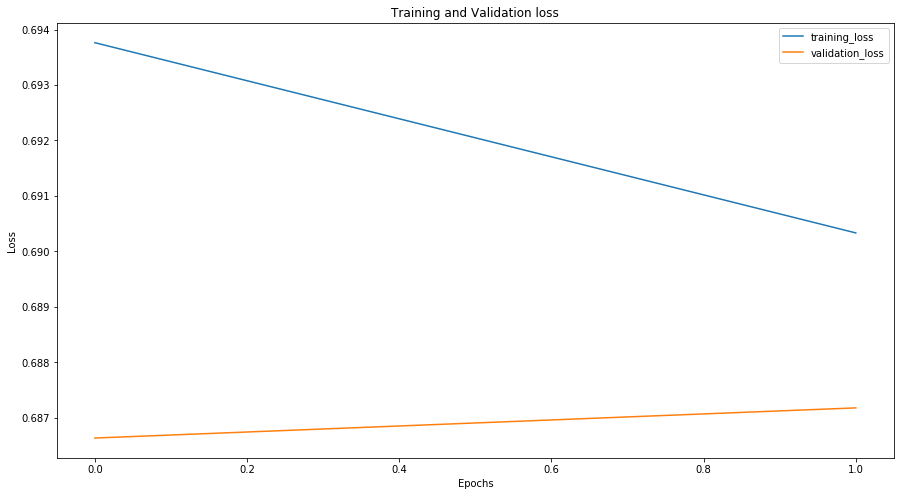

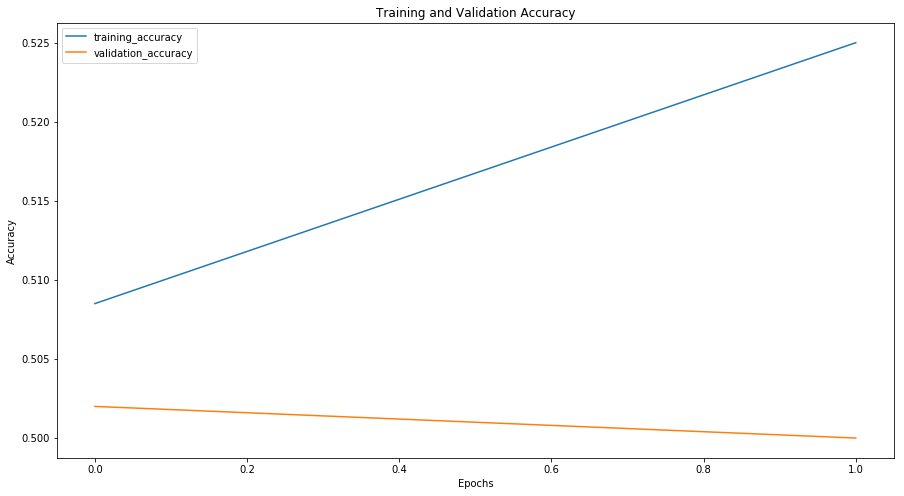

In [8]:
model.training()

In [14]:
from keras.models import load_model

In [15]:
LOGDIR = '/Volumes/Study/GitHub/neural-nets/graphs/cats-dogs/'

In [16]:
model = load_model(os.path.join(LOGDIR, 'cat_dog_v3_1.h5'))

In [17]:
test_dir = '/Volumes/Study/GitHub/data/cats-dogs/test/'

In [18]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [19]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=(150, 150),
                                                 batch_size=1,
                                                 shuffle=False,
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


In [20]:
model.evaluate_generator(test_generator)

[0.4969037559777062, 0.743]

In [21]:
test_generator.reset()

In [22]:
nb = len(test_generator.filenames)

In [23]:
test_generator.class_indices

{'cats': 0, 'dogs': 1}

In [24]:
test_generator.filenames

['cats/cat.1501.jpg',
 'cats/cat.1502.jpg',
 'cats/cat.1503.jpg',
 'cats/cat.1504.jpg',
 'cats/cat.1505.jpg',
 'cats/cat.1506.jpg',
 'cats/cat.1507.jpg',
 'cats/cat.1508.jpg',
 'cats/cat.1509.jpg',
 'cats/cat.1510.jpg',
 'cats/cat.1511.jpg',
 'cats/cat.1512.jpg',
 'cats/cat.1513.jpg',
 'cats/cat.1514.jpg',
 'cats/cat.1515.jpg',
 'cats/cat.1516.jpg',
 'cats/cat.1517.jpg',
 'cats/cat.1518.jpg',
 'cats/cat.1519.jpg',
 'cats/cat.1520.jpg',
 'cats/cat.1521.jpg',
 'cats/cat.1522.jpg',
 'cats/cat.1523.jpg',
 'cats/cat.1524.jpg',
 'cats/cat.1525.jpg',
 'cats/cat.1526.jpg',
 'cats/cat.1527.jpg',
 'cats/cat.1528.jpg',
 'cats/cat.1529.jpg',
 'cats/cat.1530.jpg',
 'cats/cat.1531.jpg',
 'cats/cat.1532.jpg',
 'cats/cat.1533.jpg',
 'cats/cat.1534.jpg',
 'cats/cat.1535.jpg',
 'cats/cat.1536.jpg',
 'cats/cat.1537.jpg',
 'cats/cat.1538.jpg',
 'cats/cat.1539.jpg',
 'cats/cat.1540.jpg',
 'cats/cat.1541.jpg',
 'cats/cat.1542.jpg',
 'cats/cat.1543.jpg',
 'cats/cat.1544.jpg',
 'cats/cat.1545.jpg',
 'cats/cat

In [25]:
predictions = model.predict_generator(test_generator, steps=nb)

In [26]:
predictions.shape

(1000, 1)

In [27]:
predictions[:5]

array([[0.801361  ],
       [0.706556  ],
       [0.519826  ],
       [0.42006403],
       [0.3000878 ]], dtype=float32)

In [34]:
for i in range(len(predictions)):
    if predictions[i] < 0.5:
        predictions[i] = 0
    else:
        predictions[i] = 1

In [35]:
predictions[:5]

array([[1.],
       [1.],
       [1.],
       [0.],
       [0.]], dtype=float32)

In [48]:
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [49]:
predicted_class = [labels[k.astype('int32')] for k in predictions.flatten()]

In [51]:
predicted_class[:5]

['dogs', 'dogs', 'dogs', 'cats', 'cats']